In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# make X, y

In [6]:
DATE_TIME = "2021-11-18_20-39-00"

In [7]:
# get list 
list_path_sample_img = []
list_path_sample_img.extend(glob.glob(PATH_DATA_SAMPLE+"/"+DATE_TIME+ "/"+ "*.pklz"))

In [8]:
# split train, validation, test set
list_path_sample_img_train, list_path_sample_img_test  = train_test_split(list_path_sample_img, test_size=0.2)
list_path_sample_img_train, list_path_sample_img_valid = train_test_split(list_path_sample_img_train, test_size=0.2)

In [9]:
def make_Xy(list_path_sample_img: list) -> (np.array, np.array):
    X = np.ndarray( (len(list_path_sample_img), IMG_SIZE, IMG_SIZE, 3) ,dtype = "float16")
    y = np.array([""] * len(list_path_sample_img))
    for i, path in tqdm(enumerate(list_path_sample_img)):
        
        X[i] = utils.pickle_read(path).astype("float16")
    
        _, file_name, _ = utils.split_file_info(path)
        y[i] = file_name[0]
    
    return X, y
    

In [10]:
X_train, y_train  = make_Xy(list_path_sample_img_train)

12800it [00:14, 903.79it/s]


In [11]:
X_valid, y_valid  = make_Xy(list_path_sample_img_valid)

3200it [00:03, 926.94it/s]


In [12]:
X_test, y_test  = make_Xy(list_path_sample_img_test)

4000it [00:04, 899.05it/s]


# model_cnn

* Ref: https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

In [13]:
BATCH_SIZE = 500
NUM_CLASSES = 2
EPOCHS = 15
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [14]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [15]:
le = LabelEncoder()

In [16]:
y_train_enc = le.fit_transform(y_train)

In [17]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [18]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [19]:
#!pip uninstall tensorflow

Créer un fichier .reg avec les instructions suivantes :

===

Windows Registry Editor Version 5.00

[HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem]
"LongPathsEnabled"=dword:00000001

---

Exécuter le .reg

In [20]:
#!pip install tensorflow

In [21]:
import tensorflow as tf

In [22]:
from keras.models import Sequential

In [23]:
model_cnn = Sequential()
model_cnn.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [24]:
# compiler modele
model_cnn.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [25]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_hidden (Dense)        (None, 256)               8388864   
                                                                 
 ouput (Dense)               (None, 1)                 257       
                                                                 
Total params: 8,390,017
Trainable params: 8,390,017
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.callbacks import EarlyStopping

In [27]:
# es = EarlyStopping(mode='min', monitor='val_loss')

In [28]:
history = model_cnn.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 18s 654ms/step - loss: 14.4929 - accuracy: 0.5176 - val_loss: 4.6620 - val_accuracy: 0.5094
Epoch 2/15
26/26 [==============================] - 16s 628ms/step - loss: 1.8800 - accuracy: 0.5857 - val_loss: 1.2432 - val_accuracy: 0.5681
Epoch 3/15
26/26 [==============================] - 16s 633ms/step - loss: 0.7031 - accuracy: 0.6651 - val_loss: 0.6201 - val_accuracy: 0.6794
Epoch 4/15
26/26 [==============================] - 16s 632ms/step - loss: 0.5970 - accuracy: 0.6834 - val_loss: 0.6139 - val_accuracy: 0.6678
Epoch 5/15
26/26 [==============================] - 16s 635ms/step - loss: 0.5655 - accuracy: 0.7148 - val_loss: 0.6091 - val_accuracy: 0.6616
Epoch 6/15
26/26 [==============================] - 16s 633ms/step - loss: 0.6098 - accuracy: 0.6713 - val_loss: 0.8331 - val_accuracy: 0.5822
Epoch 7/15
26/26 [==============================] - 16s 632ms/step - loss: 0.6733 - accuracy: 0.6601 - val_loss: 0.6022 - val_accuracy: 0.698

In [29]:
history.history

{'loss': [14.492919921875,
  1.879981517791748,
  0.7031097412109375,
  0.5970156192779541,
  0.5655335783958435,
  0.6097965836524963,
  0.673307478427887,
  0.5505918264389038,
  0.5533512234687805,
  0.5680277347564697,
  0.5904393792152405,
  0.6633522510528564,
  0.7076021432876587,
  0.531328558921814,
  0.5084639191627502],
 'accuracy': [0.517578125,
  0.5857031345367432,
  0.6650781035423279,
  0.6834375262260437,
  0.7147656083106995,
  0.6713281273841858,
  0.6600781083106995,
  0.7284374833106995,
  0.7178906202316284,
  0.7137500047683716,
  0.7010156512260437,
  0.6758593916893005,
  0.6594531536102295,
  0.7421093583106995,
  0.7541406154632568],
 'val_loss': [4.661953449249268,
  1.2432347536087036,
  0.6201465129852295,
  0.6138918995857239,
  0.609139621257782,
  0.8331092596054077,
  0.602247416973114,
  0.5811394453048706,
  0.5723382234573364,
  0.5764080286026001,
  0.8051626086235046,
  1.002732276916504,
  0.5806928873062134,
  0.6028499007225037,
  0.76909804344

In [30]:
print(model_cnn.metrics_names)

['loss', 'accuracy']


In [31]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

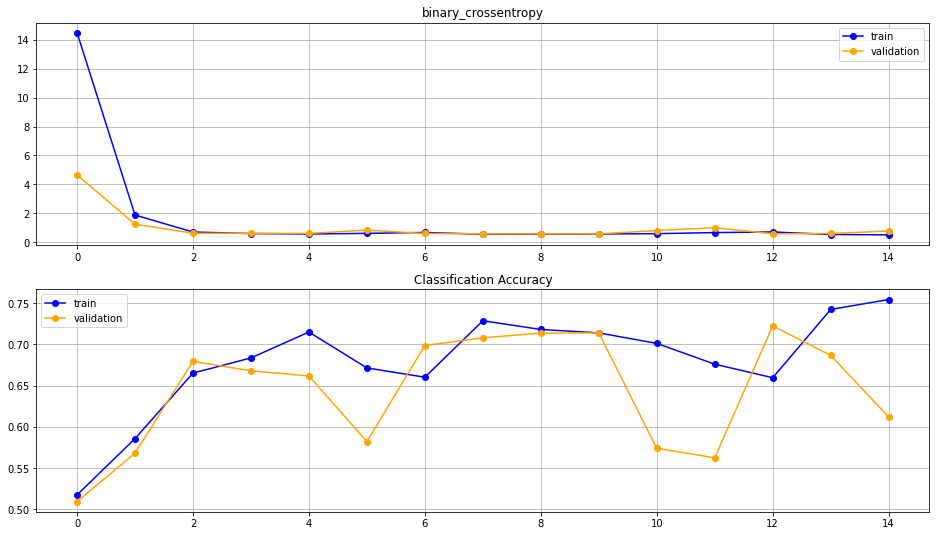

In [32]:
plot_history(history)

In [33]:
model_cnn_2 = Sequential()
model_cnn_2.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                     filters=64,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [34]:
# compiler modele
model_cnn_2.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [35]:
model_cnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_hidden (Dense)        (None, 256)               4194560   
                                                                 
 dense_hidden_2 (Dense)      (None, 128)              

In [36]:
history_2 = model_cnn_2.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 32s 1s/step - loss: 2.0882 - accuracy: 0.5615 - val_loss: 0.6623 - val_accuracy: 0.5997
Epoch 2/15
26/26 [==============================] - 31s 1s/step - loss: 0.6178 - accuracy: 0.6637 - val_loss: 0.5852 - val_accuracy: 0.7028
Epoch 3/15
26/26 [==============================] - 31s 1s/step - loss: 0.5699 - accuracy: 0.7103 - val_loss: 0.5598 - val_accuracy: 0.7194
Epoch 4/15
26/26 [==============================] - 30s 1s/step - loss: 0.5473 - accuracy: 0.7253 - val_loss: 0.5331 - val_accuracy: 0.7456
Epoch 5/15
26/26 [==============================] - 30s 1s/step - loss: 0.5084 - accuracy: 0.7534 - val_loss: 0.4986 - val_accuracy: 0.7644
Epoch 6/15
26/26 [==============================] - 30s 1s/step - loss: 0.4691 - accuracy: 0.7753 - val_loss: 0.4631 - val_accuracy: 0.7875
Epoch 7/15
26/26 [==============================] - 30s 1s/step - loss: 0.4318 - accuracy: 0.7999 - val_loss: 0.6309 - val_accuracy: 0.6650
Epoch 8/15
26/26 [==

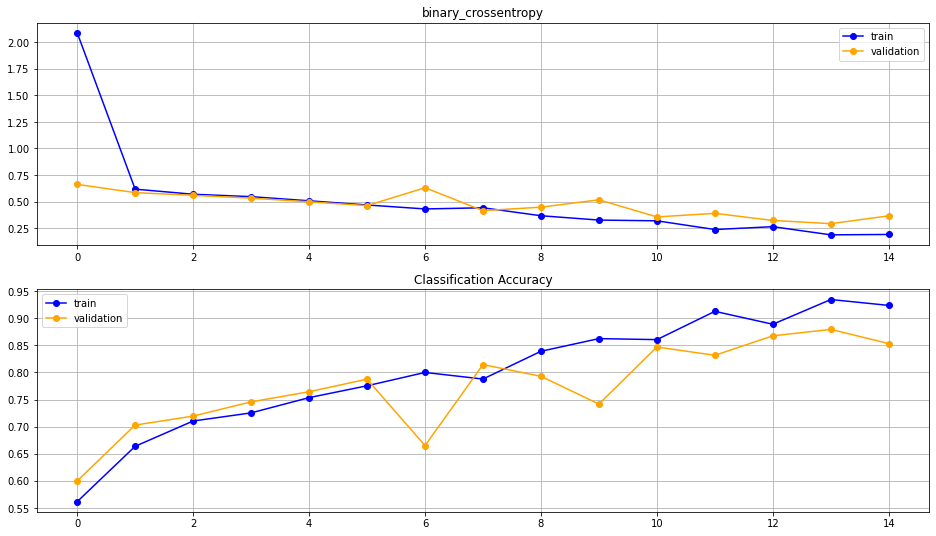

In [37]:
plot_history(history_2)

In [38]:
# modele article

In [39]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [40]:

model_cnn_3 = Sequential()
model_cnn_3.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))

model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D",
                                       filters=32,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                       filters=64,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_2",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name="conv2D_3",
                                       filters=128,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                      ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_3",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_1",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden_2",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_2",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

In [41]:
# compiler modele
model_cnn_3.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [42]:
model_cnn_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [43]:
history_3 = model_cnn_3.fit(X_train, y_train_enc,
                            epochs=EPOCHS, validation_data=(X_valid, y_valid_enc),
                            batch_size = BATCH_SIZE
                           )

Epoch 1/25
200/200 [==============================] - 43s 214ms/step - loss: 0.6268 - accuracy: 0.6363 - val_loss: 0.2912 - val_accuracy: 0.8822
Epoch 2/25
200/200 [==============================] - 42s 209ms/step - loss: 0.2082 - accuracy: 0.9288 - val_loss: 0.1663 - val_accuracy: 0.9428
Epoch 3/25
200/200 [==============================] - 43s 213ms/step - loss: 0.1457 - accuracy: 0.9535 - val_loss: 0.1469 - val_accuracy: 0.9553
Epoch 4/25
200/200 [==============================] - 42s 209ms/step - loss: 0.1272 - accuracy: 0.9586 - val_loss: 0.1472 - val_accuracy: 0.9516
Epoch 5/25
200/200 [==============================] - 43s 214ms/step - loss: 0.1169 - accuracy: 0.9597 - val_loss: 0.1336 - val_accuracy: 0.9563
Epoch 6/25
200/200 [==============================] - 44s 222ms/step - loss: 0.1049 - accuracy: 0.9631 - val_loss: 0.1538 - val_accuracy: 0.9503
Epoch 7/25
200/200 [==============================] - 43s 214ms/step - loss: 0.0868 - accuracy: 0.9699 - val_loss: 0.1409 - val_ac

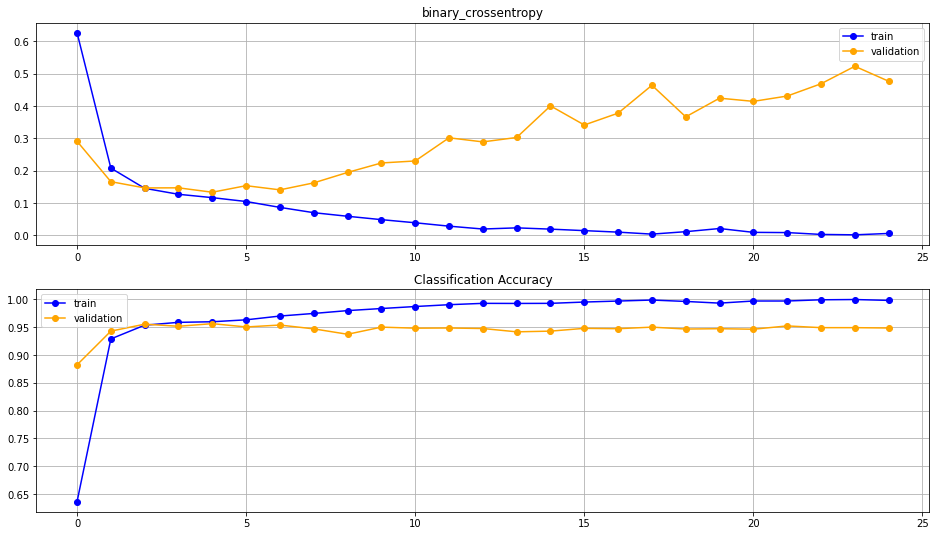

In [44]:
plot_history(history_3)

Keras avec GPU AMD
https://medium.com/@Vatsal410/keras-without-nvidia-gpus-with-plaidml-and-amd-gpu-4ba6f60025ce